## loading dataset

In [10]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d subhajournal/phishingemails
!unzip phishingemails.zip

cp: kaggle.json: No such file or directory
Dataset URL: https://www.kaggle.com/datasets/subhajournal/phishingemails
License(s): GNU Lesser General Public License 3.0
phishingemails.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  phishingemails.zip
replace Phishing_Email.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
import pandas as pd

df = pd.read_csv('Phishing_Email.csv')
df

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email
...,...,...,...
18645,18646,date a lonely housewife always wanted to date ...,Phishing Email
18646,18647,request submitted : access request for anita ....,Safe Email
18647,18648,"re : important - prc mtg hi dorn & john , as y...",Safe Email
18648,18649,press clippings - letter on californian utilit...,Safe Email


## Prepocessing

clean up the skips

In [5]:
df.isnull().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

In [7]:
df = df.drop(["Unnamed: 0"],axis=1).dropna(axis=0).drop_duplicates()
print(df.shape)
df.head()

(17538, 2)


,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


translate the values into the target variable 

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df["Email Type"] = le.fit_transform(df["Email Type"])
df

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",1
1,the other side of * galicismos * * galicismo *...,1
2,re : equistar deal tickets are you still avail...,1
3,\nHello I am your hot lil horny toy.\n I am...,0
4,software at incredibly low prices ( 86 % lower...,0
...,...,...
18644,\nRick Moen a Ã©crit:> > I'm confused. I thou...,1
18645,date a lonely housewife always wanted to date ...,0
18646,request submitted : access request for anita ....,1
18647,"re : important - prc mtg hi dorn & john , as y...",1


### Vectorizing

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np

tfidf = TfidfVectorizer(stop_words="english",max_features=10000)
X = tfidf.fit_transform(df["Email Text"]).toarray()
y = np.array(df['Email Type'])

### Split into training and test sample

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

## Application of different models

### Metrics

In [20]:
from sklearn.metrics import (accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate

def show_mean_metrics(model_name, model, X, y, as_percentage=True):
    scoring = ['accuracy', 'f1', 'recall', 'precision']
    scores = cross_validate(model, X, y, cv=5, scoring=scoring)
    
    # Compute means and standard deviations
    multiplier = 100 if as_percentage else 1
    accuracy = round(scores['test_accuracy'].mean() * multiplier, 2)
    accuracy_std = round(scores['test_accuracy'].std() * multiplier, 2)
    
    recall = round(scores['test_recall'].mean() * multiplier, 2)
    recall_std = round(scores['test_recall'].std() * multiplier, 2)
    
    precision = round(scores['test_precision'].mean() * multiplier, 2)
    precision_std = round(scores['test_precision'].std() * multiplier, 2)
    
    f1 = round(scores['test_f1'].mean() * multiplier, 2)
    f1_std = round(scores['test_f1'].std() * multiplier, 2)
    
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}% (±{accuracy_std}%)")
    print(f"Recall: {recall}% (±{recall_std}%)")
    print(f"Precision: {precision}% (±{precision_std}%)")
    print(f"F1 Score: {f1}% (±{f1_std}%)")

    return model_name, accuracy, accuracy_std, recall, recall_std, precision, precision_std, f1, f1_std

In [30]:
result = []

### LogisticRegression

In [32]:
from sklearn.linear_model import LogisticRegression


lg = LogisticRegression(penalty=None)
lg.fit(X_train, y_train)

y_pred = lg.predict(X_test)

results.append(show_mean_metrics('LogisticRegression', lg, X_train, y_train))

Model: LogisticRegression
Accuracy: 97.8% (±0.23%)
Recall: 98.22% (±0.36%)
Precision: 98.28% (±0.17%)
F1 Score: 98.25% (±0.18%)


### RandomForestClassifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

rnf_clf = RandomForestClassifier(n_estimators=120, random_state=0)
rnf_clf.fit(X_train, y_train)

y_pred = rnf_clf.predict(X_test)

results.append(show_mean_metrics('RandomForestClassifier', rnf_clf, X_train, y_train))

Model: RandomForestClassifier
Accuracy: 96.91% (±0.33%)
Recall: 97.11% (±0.35%)
Precision: 97.96% (±0.23%)
F1 Score: 97.54% (±0.26%)


### SGDClassifier

In [36]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(n_jobs=20, random_state=0)
sgd_clf.fit(X_train, y_train)

y_pred = sgd_clf.predict(X_test)

results.append(show_mean_metrics('SGDClassifier', sgd_clf, X_train, y_train))

Model: SGDClassifier
Accuracy: 98.08% (±0.24%)
Recall: 98.55% (±0.25%)
Precision: 98.39% (±0.38%)
F1 Score: 98.47% (±0.19%)


### XGBClassifier

In [37]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, max_depth=10)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

results.append(show_mean_metrics('XGBClassifier', xgb, X_train, y_train))

Model: XGBClassifier
Accuracy: 96.89% (±0.24%)
Recall: 96.96% (±0.32%)
Precision: 98.07% (±0.24%)
F1 Score: 97.51% (±0.19%)


In [48]:
results

[('LogisticRegression', 97.8, 0.23, 98.22, 0.36, 98.28, 0.17, 98.25, 0.18),
 ('RandomForestClassifier',
  96.91,
  0.33,
  97.11,
  0.35,
  97.96,
  0.23,
  97.54,
  0.26),
 ('SGDClassifier', 98.08, 0.24, 98.55, 0.25, 98.39, 0.38, 98.47, 0.19),
 ('XGBClassifier', 96.89, 0.24, 96.96, 0.32, 98.07, 0.24, 97.51, 0.19)]

### Comparison of model quality metrics

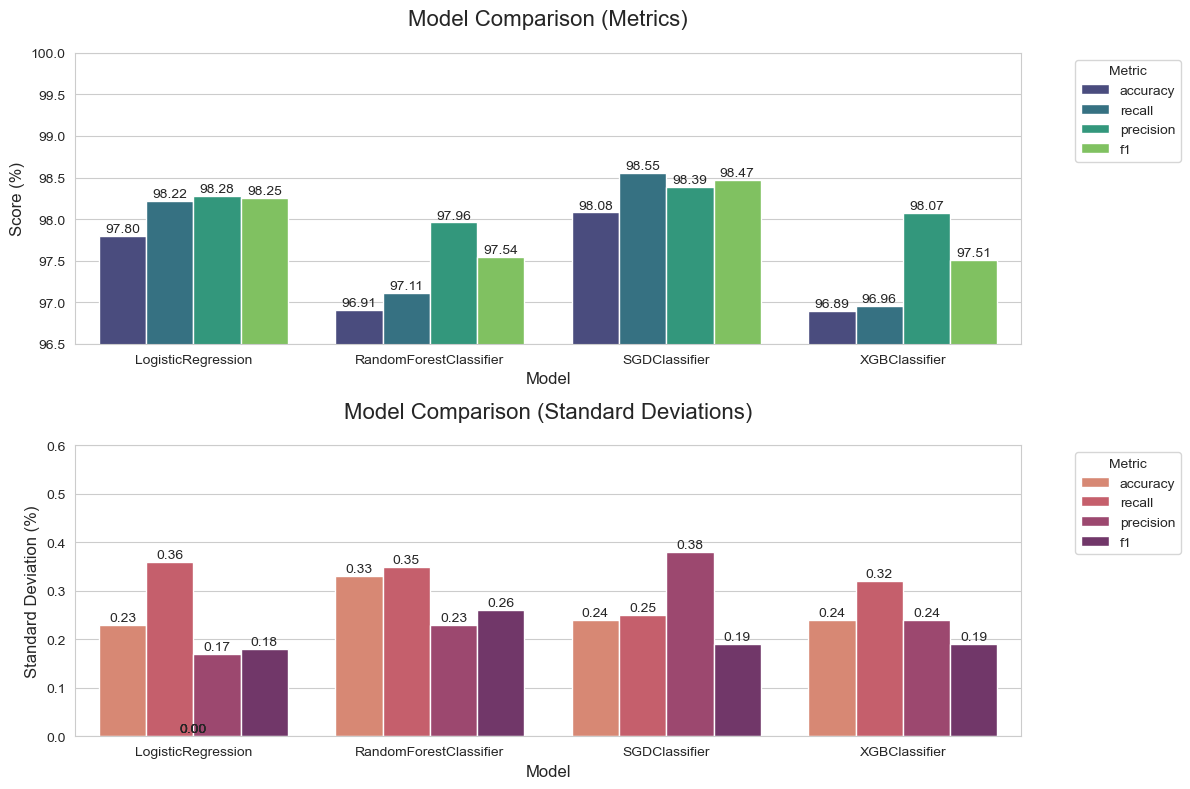

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

metrics_df = pd.DataFrame(
    results,
    columns=['name', 'accuracy', 'accuracy_std', 'recall', 'recall_std', 
             'precision', 'precision_std', 'f1', 'f1_std']
)

df_metrics = metrics_df.melt(id_vars='name', value_vars=['accuracy', 'recall', 'precision', 'f1'], var_name='metric', value_name='score')

# Preparing data for the std barplot
df_std = metrics_df.melt(
    id_vars='name',
    value_vars=['accuracy_std', 'recall_std', 'precision_std', 'f1_std'],
    var_name='metric',
    value_name='std'
)
df_std['metric'] = df_std['metric'].str.replace('_std', '')

# Create a shape with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
sns.set_style("whitegrid")

# metrics
sns.barplot(x='name', y='score', hue='metric', data=df_metrics, palette='viridis',ax=ax1)
ax1.set_title('Model Comparison (Metrics)', fontsize=16, pad=20)
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Score (%)', fontsize=12)
ax1.set_ylim(96.5, 100)
ax1.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

for p in ax1.patches:
    ax1.annotate(
        f"{p.get_height():.2f}", 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', 
        va='center', 
        xytext=(0, 5), 
        textcoords='offset points'
    )

# std
sns.barplot(x='name', y='std', hue='metric', data=df_std, palette='flare',ax=ax2)
ax2.set_title('Model Comparison (Standard Deviations)', fontsize=16, pad=20)
ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('Standard Deviation (%)', fontsize=12)
ax2.set_ylim(0, 0.6)  # Диапазон для погрешностей
ax2.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

for p in ax2.patches:
    ax2.annotate(
        f"{p.get_height():.2f}", 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', 
        va='center', 
        xytext=(0, 5), 
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

The SGDClassifier outperforms other models for phishing detection with superior 98.55% recall (±0.25) - significantly higher than competitors like LogisticRegression (98.22%) and XGBoost (96.96%).
The model's combination of highest threat identification and consistent reliability makes it the clear choice for security-critical email systems.